In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
from datetime import datetime
import re

from sklearn import metrics

pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

In [2]:
os.chdir('../Data')

In [3]:
df=pd.read_csv('./train.csv')
df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,03-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,26-09-18,6,1998,1,1,0,0,0,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,01-08-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,26-10-18,6,1998,1,1,0,0,0,0,305,L-Very High Risk,3,0,0,0,0,0,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,26-09-18,6,1998,1,1,0,0,0,0,0,No Bureau History Available,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


In [4]:
pres_date='01-01-20'
def days_between(d1,d2):
    d1=datetime.strptime(d1,'%d-%m-%y')
    d2=datetime.strptime(d2,'%d-%m-%y')
    return abs((d2-d1).days)

In [5]:
df['Date.of.Birth']=df['Date.of.Birth'].apply(lambda x:days_between(x,pres_date)/365) # converting date of birth in years
df['DisbursalDate']=df['DisbursalDate'].apply(lambda x:days_between(x,pres_date)/365) # converting disbursed date to the present date

In [6]:
def cns_score(score):
    if score<100:
        return 0
    elif (score>=100) & (score<200):
        return 1
    elif (score>=200) & (score<300):
        return 2
    elif (score>=300) & (score<400):
        return 3
    elif (score>=400) & (score<500):
        return 4
    elif (score>=500) & (score<600):
        return 5
    elif (score>=600) & (score <700):
        return 6
    elif (score>=700) & (score <800):
        return 7
    elif (score>=800) & (score <900):
        return 8
    elif (score>=900) & (score <1000):
        return 9
    else:
        return 10

In [7]:
df['PERFORM_CNS.SCORE_CAT']=df['PERFORM_CNS.SCORE'].map(lambda x:cns_score(x))

In [8]:
df.loc[:,'total.no.of.accts']=df['PRI.NO.OF.ACCTS']+df['SEC.NO.OF.ACCTS']
df.loc[:,'pri.inactive.accts']=df['PRI.NO.OF.ACCTS']-df['PRI.ACTIVE.ACCTS']
df.loc[:,'sec.inactive.accts']=df['SEC.NO.OF.ACCTS']-df['SEC.ACTIVE.ACCTS']
df.loc[:,'total.inactive.accts']=df['pri.inactive.accts']-df['sec.inactive.accts']
df.loc[:,'total.overdue.accts']=df['PRI.OVERDUE.ACCTS']+df['SEC.OVERDUE.ACCTS']
df.loc[:,'total.current.balance']=df['PRI.CURRENT.BALANCE']+df['SEC.CURRENT.BALANCE']
df.loc[:,'total.disbursed.amount']=df['PRI.DISBURSED.AMOUNT']+df['SEC.CURRENT.BALANCE']
df.loc[:,'total.sanctioned.amount']=df['PRI.SANCTIONED.AMOUNT']+df['SEC.SANCTIONED.AMOUNT']
df.loc[:,'total.installment']=df['PRIMARY.INSTAL.AMT']+df['SEC.SANCTIONED.AMOUNT']
# df.loc[:,'bal.to.disburse']=np.round((1+df['total.disbursed.amount'])/(1+df['total.current.balance']),2) # balance to disbursed anount ratio
df.loc[:,'pri.tenure']=(df['PRI.DISBURSED.AMOUNT']/(df['PRIMARY.INSTAL.AMT']+1)).astype(int)
df.loc[:,'sec.tenure']=(df['SEC.DISBURSED.AMOUNT']/(df['SEC.INSTAL.AMT']+1)).astype(int)
df.loc[:,'disburse.to.sanctioned']=np.round((1+df['total.disbursed.amount'])/(1+df['total.sanctioned.amount']),2)

In [9]:
df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda x:(re.sub('[a-z]','',x)).split())
df['AVERAGE.ACCT.AGE']=df['AVERAGE.ACCT.AGE'].apply(lambda x:int(x[0])*12+int(x[1]))

In [10]:
df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda x:
                                                                   (re.sub('[a-z]','',x)).split())
df['CREDIT.HISTORY.LENGTH']=df['CREDIT.HISTORY.LENGTH'].apply(lambda x:
                                                                   int(x[0])*12+int(x[1]))

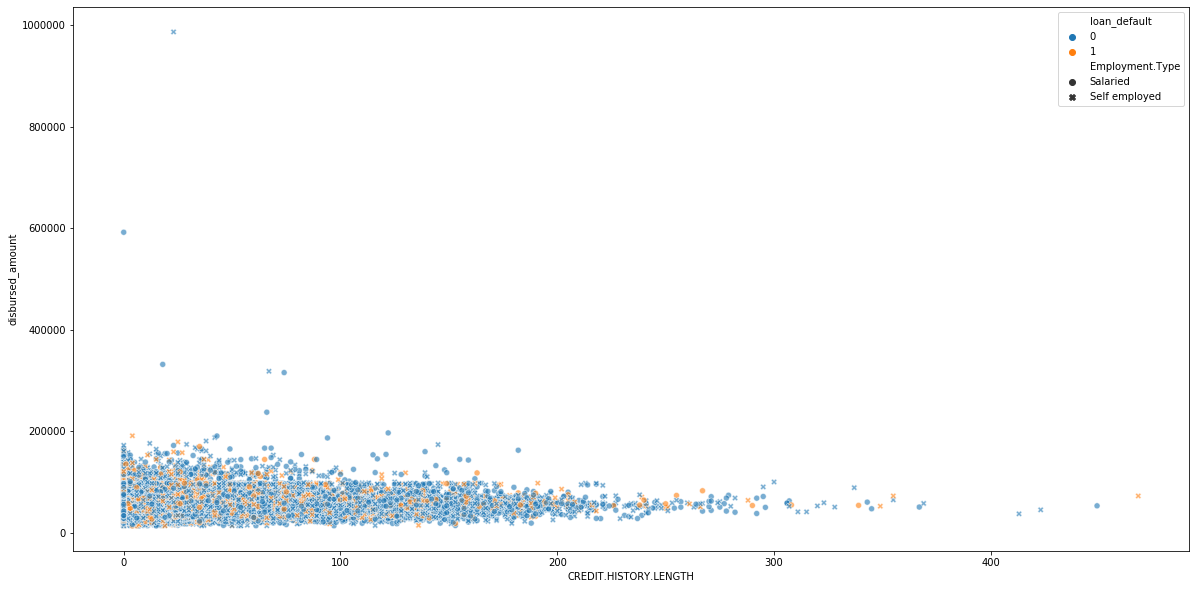

In [11]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='CREDIT.HISTORY.LENGTH',y='disbursed_amount',style='Employment.Type',hue='loan_default',alpha=0.6,data=df)
plt.show()

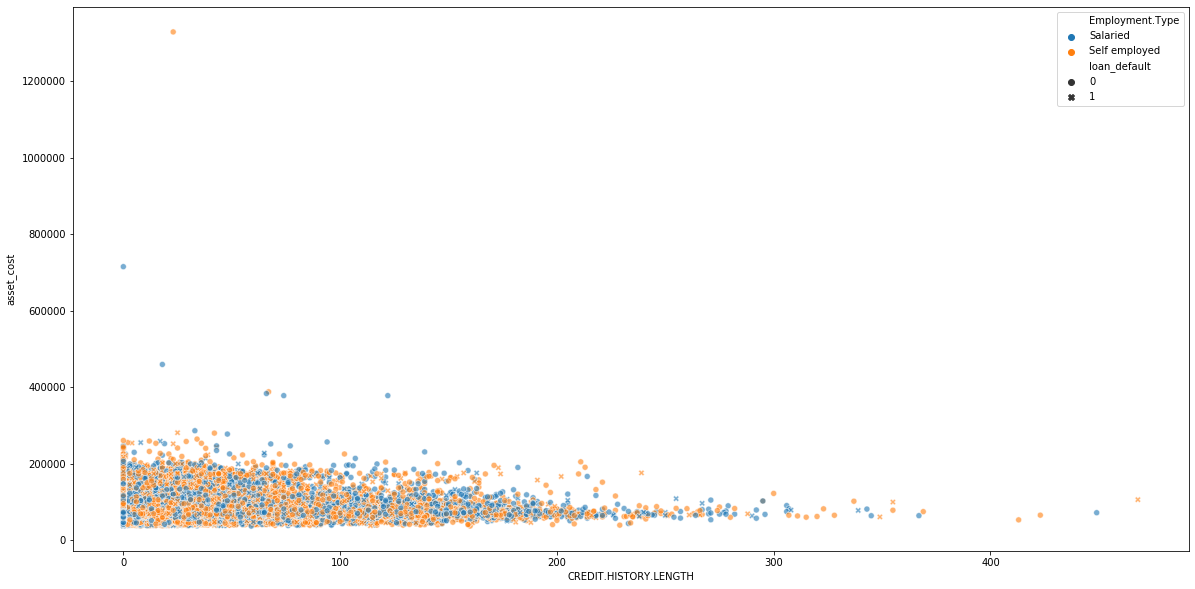

In [12]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='CREDIT.HISTORY.LENGTH',y='asset_cost',style='loan_default',hue='Employment.Type',alpha=0.6,data=df)
plt.show()

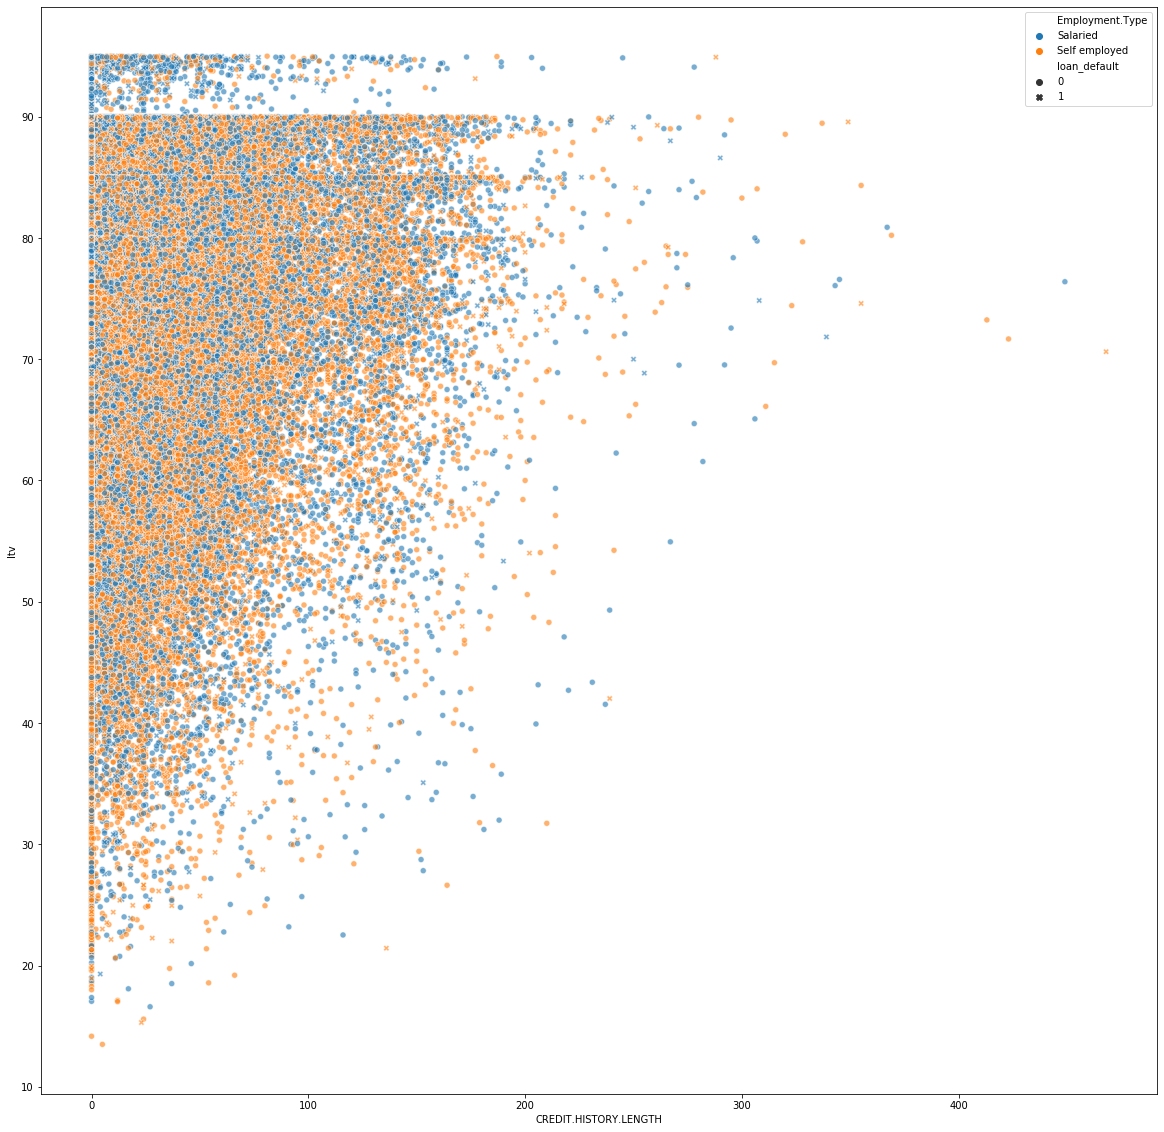

In [13]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='CREDIT.HISTORY.LENGTH',y='ltv',style='loan_default',hue='Employment.Type',alpha=0.6,data=df)
plt.show()

In [14]:
df['Employment.Type']=df['Employment.Type'].fillna('unknown')

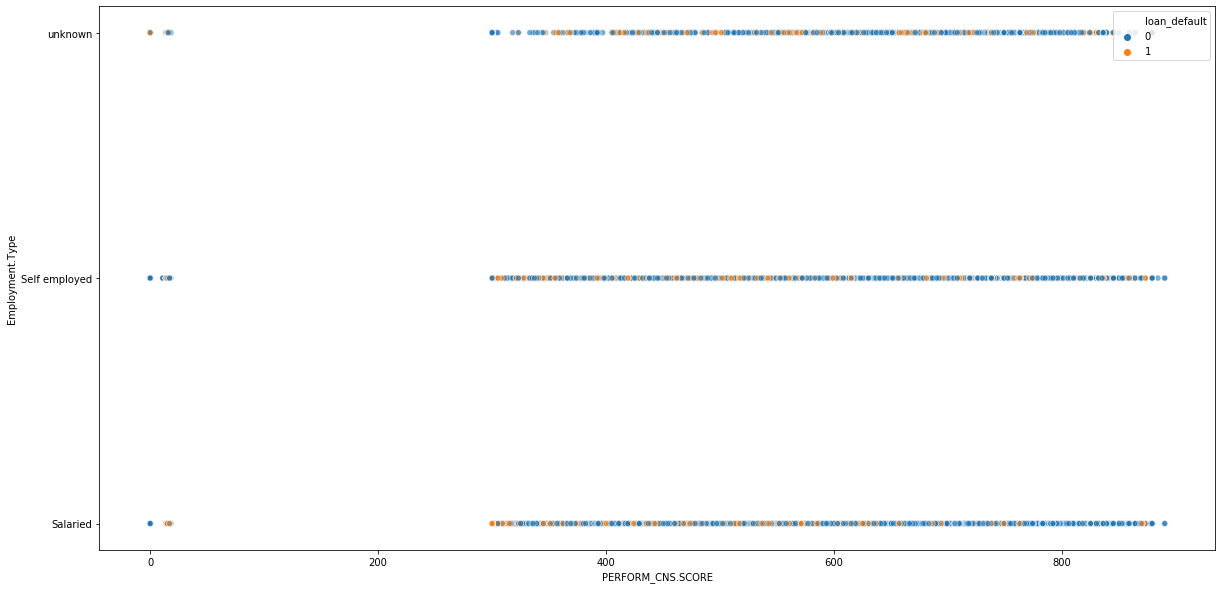

In [26]:
plt.figure(figsize=(20,10))
sns.scatterplot(x='PERFORM_CNS.SCORE',y='Employment.Type',hue='loan_default',alpha=0.6,data=df)
plt.show()

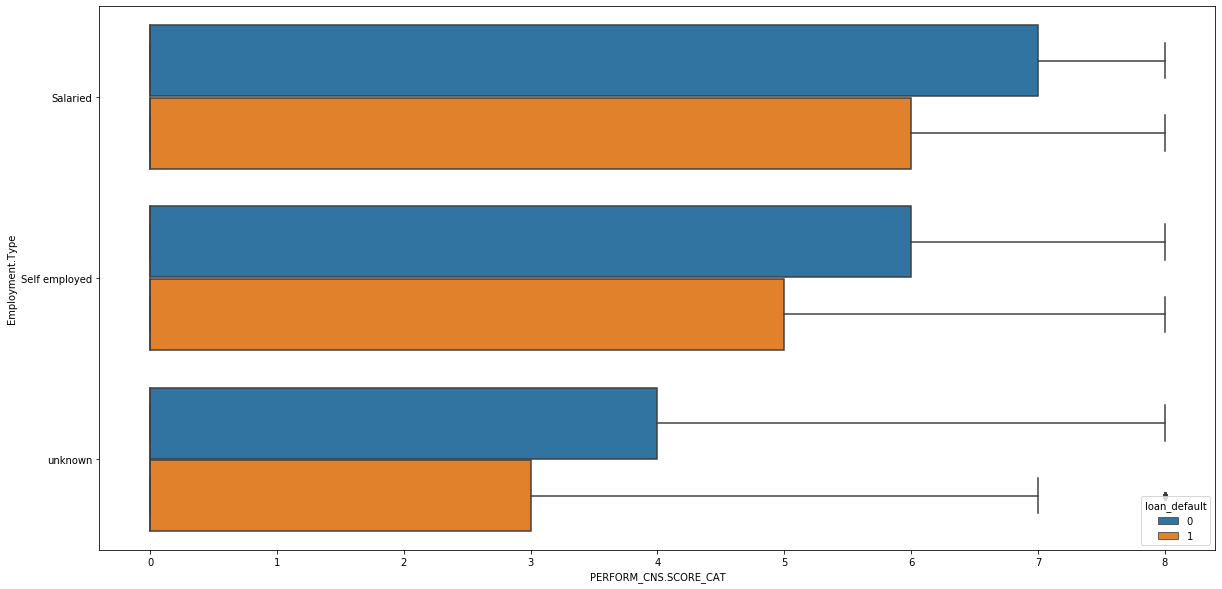

In [27]:
plt.figure(figsize=(20,10))
sns.boxplot(x='PERFORM_CNS.SCORE_CAT',y='Employment.Type',hue='loan_default',data=df)
plt.show()

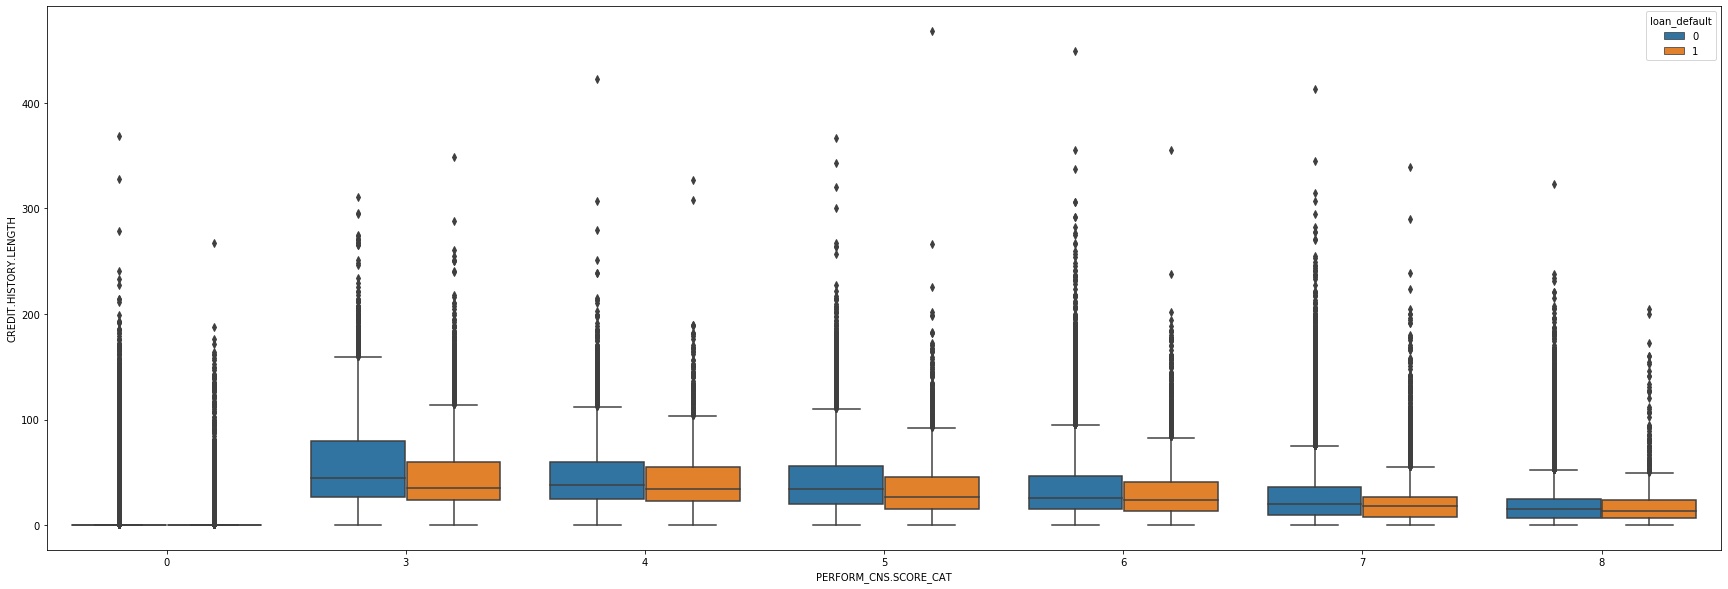

In [16]:
plt.figure(figsize=(20,20))
sns.boxplot(x='PERFORM_CNS.SCORE_CAT',y='CREDIT.HISTORY.LENGTH',hue='loan_default',data=df)
plt.show()

In [17]:
df['total.current.balance']

0              0
1          27600
2              0
3              0
4              0
           ...  
233149    390443
233150         0
233151         0
233152         0
233153         0
Name: total.current.balance, Length: 233154, dtype: int64

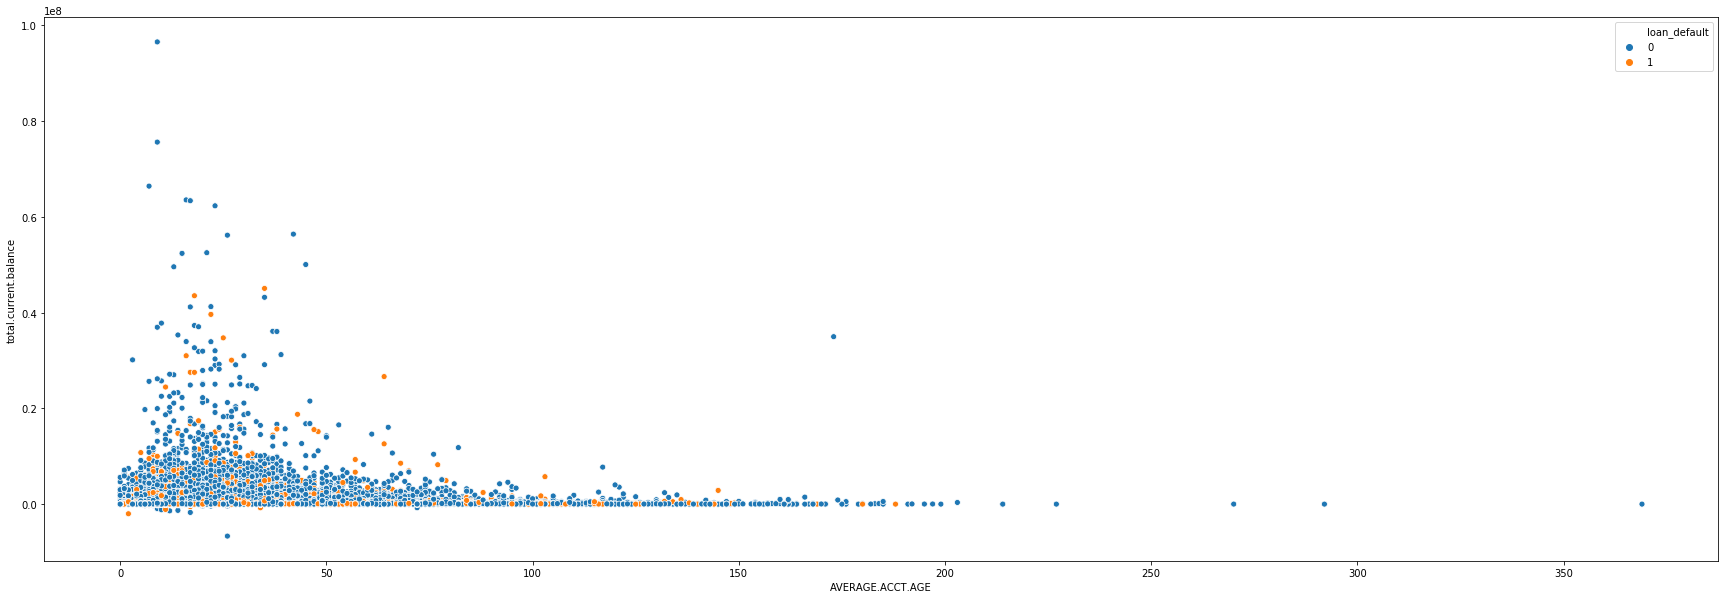

In [18]:
plt.figure(figsize=(20,20))
sns.scatterplot(x='AVERAGE.ACCT.AGE',y='total.current.balance',hue='loan_default',data=df)
plt.show()

In [19]:
df.columns

Index(['UniqueID', 'disbursed_amount', 'asset_cost', 'ltv', 'branch_id', 'supplier_id', 'manufacturer_id', 'Current_pincode_ID', 'Date.of.Birth', 'Employment.Type', 'DisbursalDate', 'State_ID', 'Employee_code_ID', 'MobileNo_Avl_Flag', 'Aadhar_flag', 'PAN_flag', 'VoterID_flag', 'Driving_flag', 'Passport_flag', 'PERFORM_CNS.SCORE', 'PERFORM_CNS.SCORE.DESCRIPTION', 'PRI.NO.OF.ACCTS', 'PRI.ACTIVE.ACCTS', 'PRI.OVERDUE.ACCTS', 'PRI.CURRENT.BALANCE', 'PRI.SANCTIONED.AMOUNT', 'PRI.DISBURSED.AMOUNT', 'SEC.NO.OF.ACCTS', 'SEC.ACTIVE.ACCTS', 'SEC.OVERDUE.ACCTS', 'SEC.CURRENT.BALANCE', 'SEC.SANCTIONED.AMOUNT', 'SEC.DISBURSED.AMOUNT', 'PRIMARY.INSTAL.AMT', 'SEC.INSTAL.AMT', 'NEW.ACCTS.IN.LAST.SIX.MONTHS', 'DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS', 'AVERAGE.ACCT.AGE', 'CREDIT.HISTORY.LENGTH', 'NO.OF_INQUIRIES', 'loan_default', 'PERFORM_CNS.SCORE_CAT', 'total.no.of.accts', 'pri.inactive.accts', 'sec.inactive.accts', 'total.inactive.accts', 'total.overdue.accts', 'total.current.balance',
       'total.disb

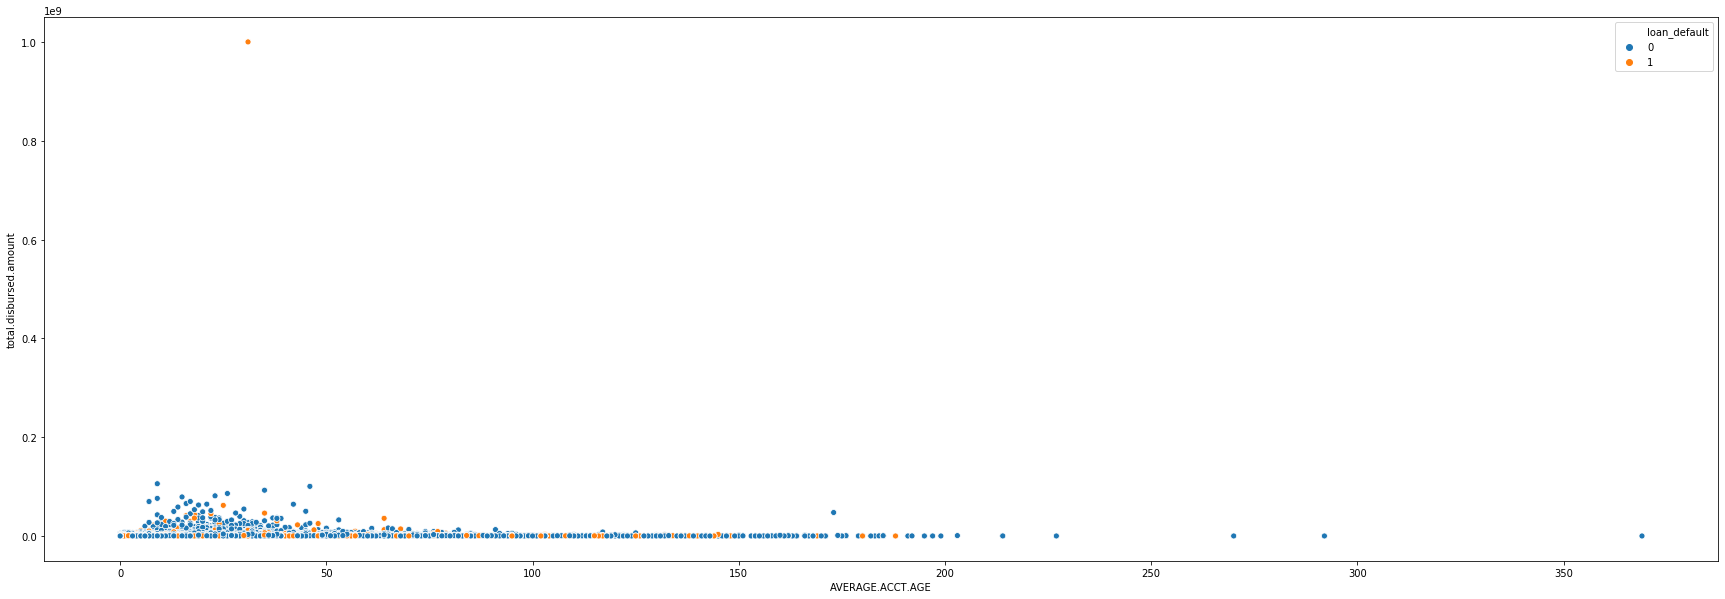

In [20]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='AVERAGE.ACCT.AGE',y='total.disbursed.amount',hue='loan_default',data=df)
plt.show()

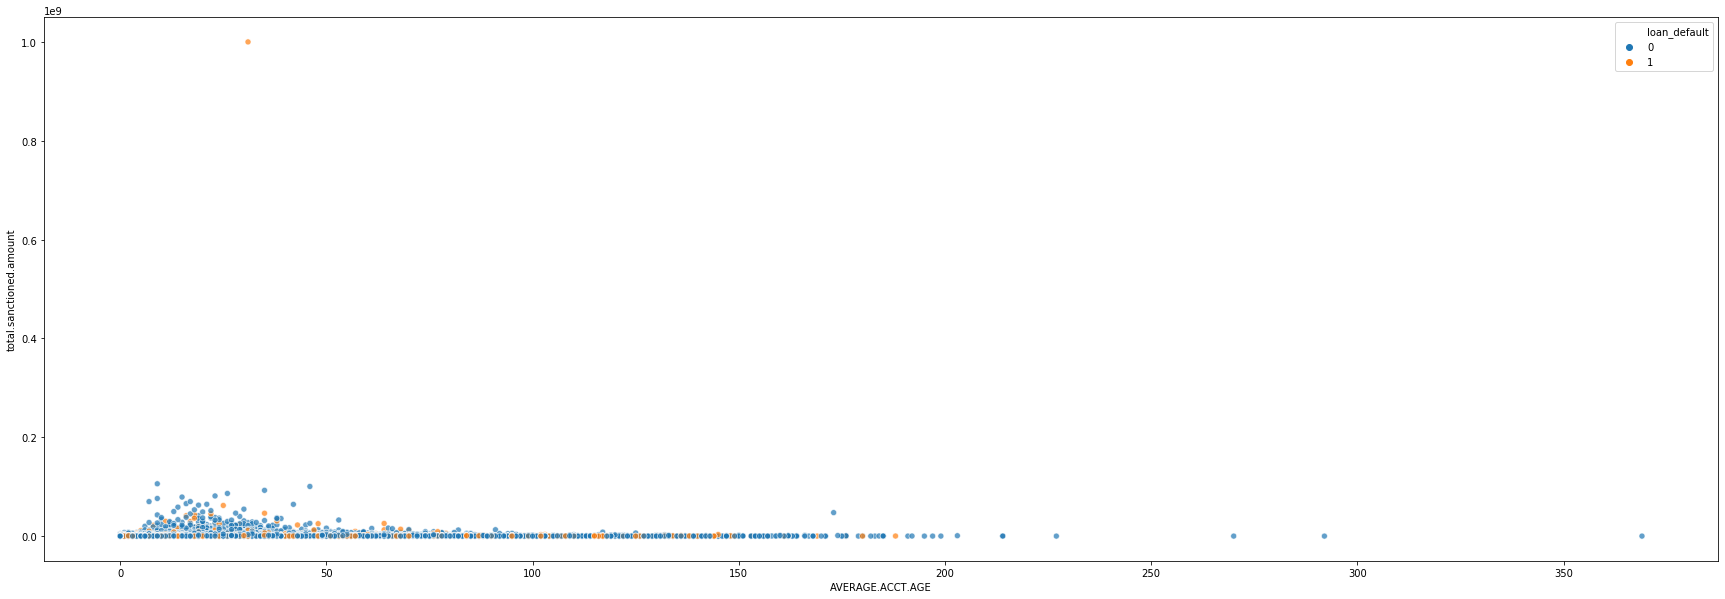

In [21]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='AVERAGE.ACCT.AGE',y='total.sanctioned.amount',hue='loan_default',alpha=0.7,data=df)
plt.show()

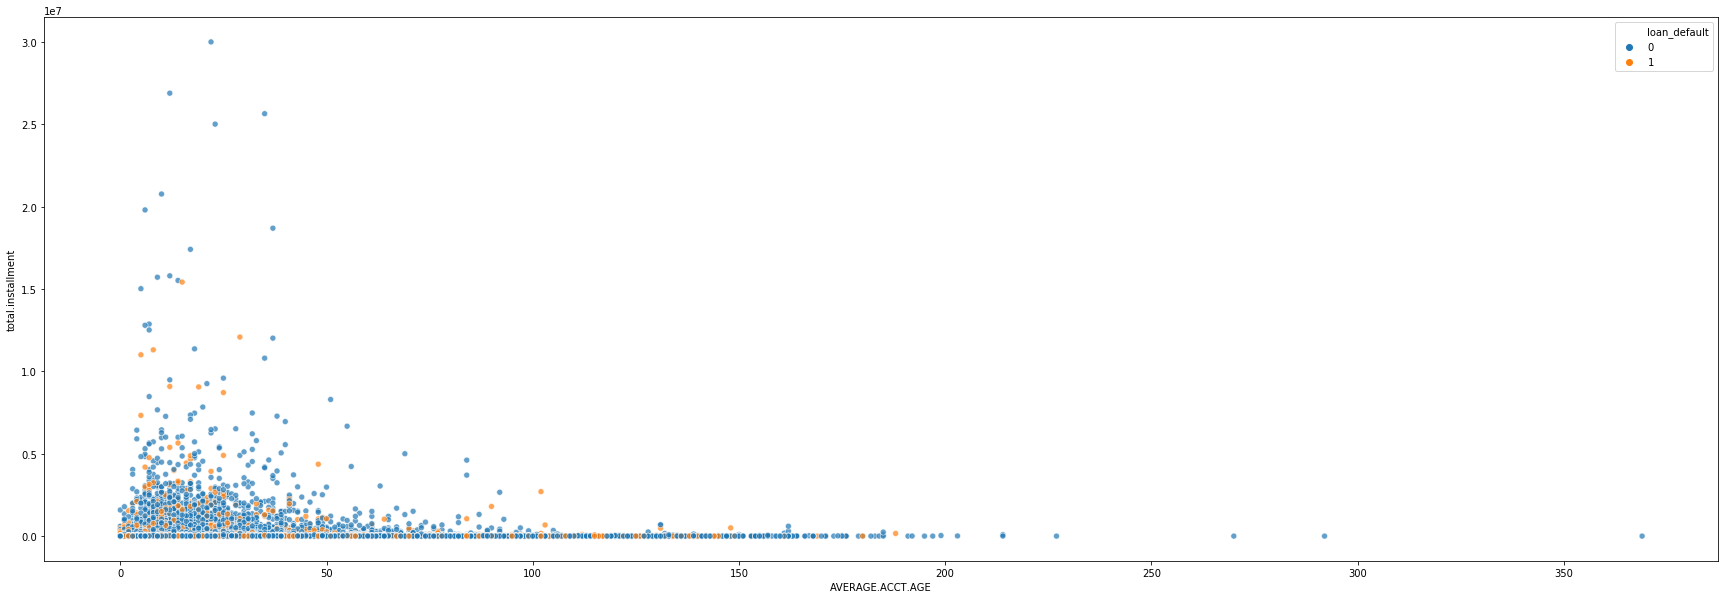

In [22]:
plt.figure(figsize=(30,10))
sns.scatterplot(x='AVERAGE.ACCT.AGE',y='total.installment',hue='loan_default',alpha=0.7,data=df)
plt.show()

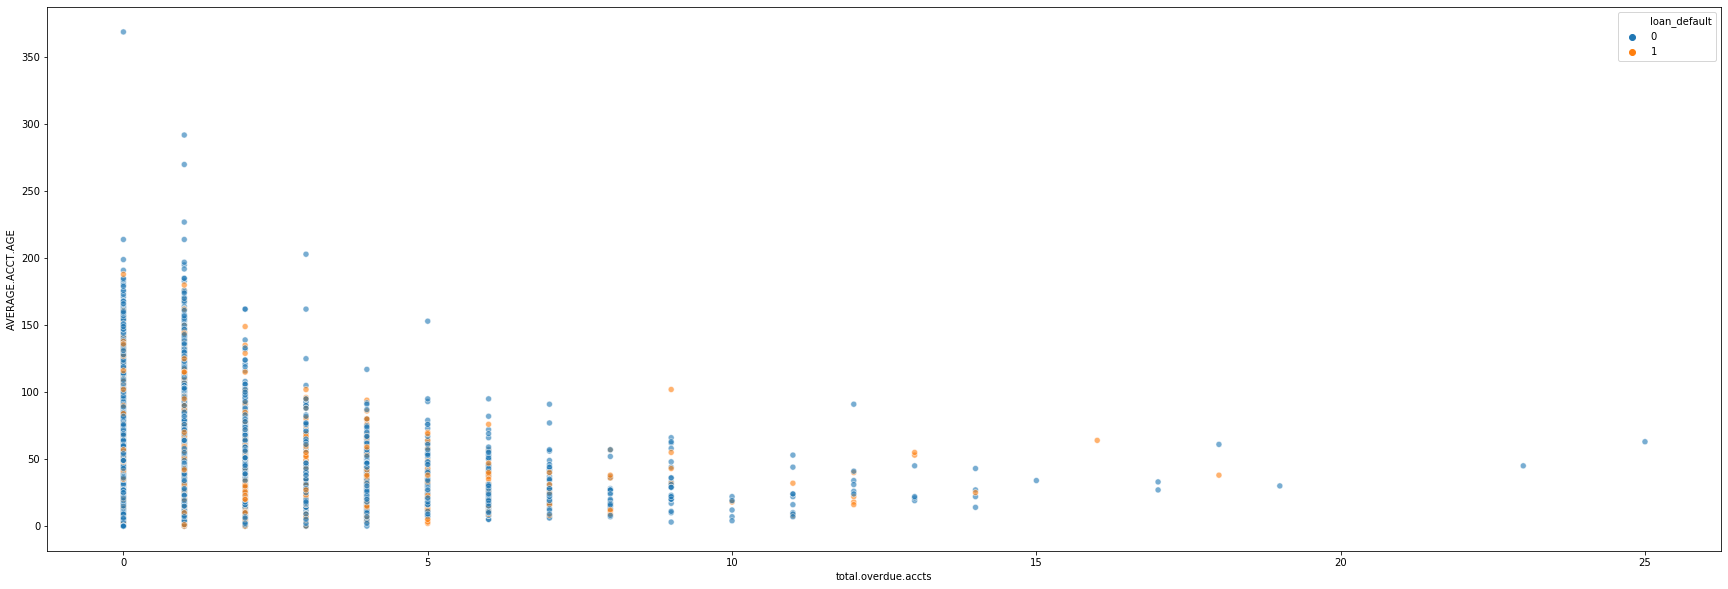

In [28]:
plt.figure(figsize=(30,10))
sns.scatterplot(y='AVERAGE.ACCT.AGE',x='total.overdue.accts',hue='loan_default',alpha=0.6,data=df)
plt.show()

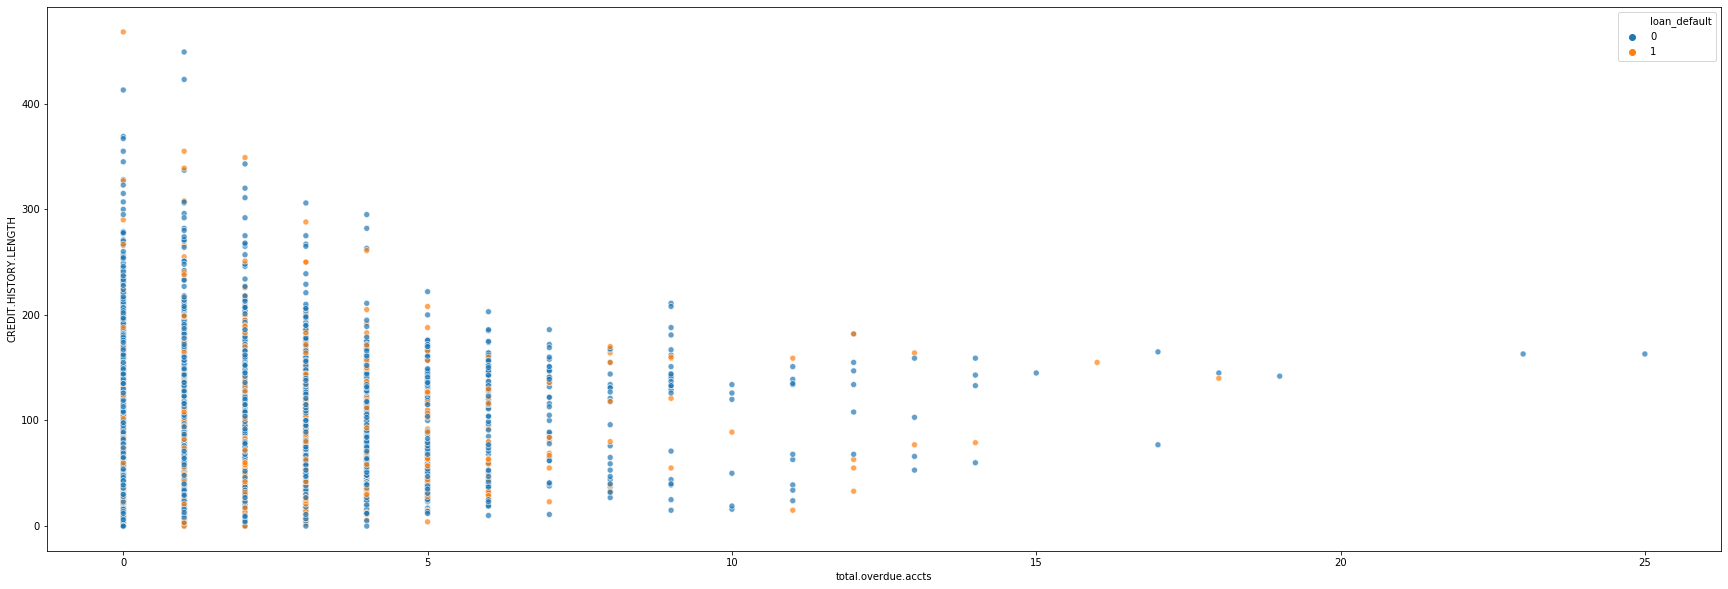

In [30]:
plt.figure(figsize=(30,10))
sns.scatterplot(y='CREDIT.HISTORY.LENGTH',x='total.overdue.accts',hue='loan_default',alpha=0.7,data=df)
plt.show()